In [52]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. 
# This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

housing.data


In [53]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. 
# All changes under this directory will be kept even after reset. 
# Please clean unnecessary files in time to speed up environment loading. 
!ls /home/aistudio/work

In [54]:
# 如果需要进行持久化安装, 需要使用持久化路径, 如下方代码示例:
# If a persistence installation is required, 
# you need to use the persistence path as the following: 
!mkdir /home/aistudio/external-libraries
!pip install beautifulsoup4 -t /home/aistudio/external-libraries

Looking in indexes: https://mirror.baidu.com/pypi/simple/
     |████████████████████████████████| 122kB 16.1MB/s eta 0:00:01


In [55]:
# 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可: 
# Also add the following code, 
# so that every time the environment (kernel) starts, 
# just run the following code: 
import sys 
sys.path.append('/home/aistudio/external-libraries')

In [56]:
import random
import paddle
import numpy as np
import paddle.nn as nn
import matplotlib.pyplot as plt
import paddle.nn.functional as F

In [57]:
def load_data():
    # 从文件导入数据
    datafile = './data/housing.data'
    data = np.fromfile(datafile, sep=' ', dtype=np.float32)

    # 每条数据包括14项，其中前面13项是影响因素，第14项是相应的房屋价格中位数
    feature_names = [ 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 
    'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV' ]
    feature_num = len(feature_names)

    # 将原始数据进行Reshape，变成[N, 14]这样的形状
    data = data.reshape([data.shape[0] // feature_num, feature_num])

    # 将原数据集拆分成训练集和测试集
    # 这里使用80%的数据做训练，20%的数据做测试
    # 测试集和训练集必须是没有交集的
    ratio = 0.8
    offset = int(data.shape[0] * ratio)
    training_data = data[:offset]

    # 计算train数据集的最大值，最小值，平均值
    maximums, minimums, avgs = training_data.max(axis=0), training_data.min(axis=0), \
    training_data.sum(axis=0) / training_data.shape[0]

    # 记录数据的归一化参数，在预测时对数据做归一化
    global max_values
    global min_values
    global avg_values
    max_values = maximums
    min_values = minimums
    avg_values = avgs

    # 对数据进行归一化处理
    for i in range(feature_num):
        data[:, i] = (data[:, i] - avgs[i]) / (maximums[i] - minimums[i])

    # 训练集和测试集的划分比例
    training_data = data[:offset]
    test_data = data[offset:]
    return training_data, test_data

In [58]:
class Regressor(paddle.nn.Layer):

     def __init__(self):
         # 初始化父类中的一些参数
         super(Regressor, self).__init__()

         # 定义两层全连接层
         self.fc1 = nn.Linear(in_features=13, out_features=10)   # 输入维度是13，输出维度是10
         self.fc2 = nn.Linear(in_features=10, out_features=10)   # 输入维度是10，输出维度是10
         self.fc3 = nn.Linear(in_features=10, out_features=1)    # 输入维度是10，输出维度是1

     # 网络的前向计算
     def forward(self, inputs):
         x = F.sigmoid(self.fc1(inputs))
         x = F.sigmoid(self.fc2(x))
         x = self.fc3(x)
         return x

In [59]:
def train(EPOCH_NUM,BATCH_SIZE):
    # 定义外层循环
    losses = []
    for epoch_id in range(EPOCH_NUM):
        # 在每轮迭代开始之前，将训练数据的顺序随机的打乱
        np.random.shuffle(training_data)
        # 将训练数据进行拆分，每个batch包含10条数据
        mini_batches = [training_data[k:k+BATCH_SIZE] for k in range(0, len(training_data), BATCH_SIZE)]
        # 定义内层循环
        for iter_id, mini_batch in enumerate(mini_batches):
            x = np.array(mini_batch[:, :-1]) # 获得当前批次训练数据
            y = np.array(mini_batch[:, -1:]) # 获得当前批次训练标签（真实房价）
            # 将numpy数据转为飞桨动态图tensor形式
            house_features = paddle.to_tensor(x)
            prices = paddle.to_tensor(y)

            # 前向计算
            predicts = model(house_features)

            # 计算损失
            loss = F.square_error_cost(predicts, label=prices)
            avg_loss = paddle.mean(loss)
            losses.append(np.squeeze(avg_loss.numpy()))
            if iter_id%20==0:
                print("epoch: {}, iter: {}, loss is: {}".format(epoch_id, iter_id, np.squeeze(avg_loss.numpy())))

            # 反向传播
            avg_loss.backward()
            # 最小化loss,更新参数
            opt.step()
            # 清除梯度
            opt.clear_grad()
    return losses

def testing():
    x = np.array(test_data[:, :-1]) # 获得当前批次训练数据
    y = np.array(test_data[:, -1:]) # 获得当前批次训练标签（真实房价）
    # 将numpy数据转为飞桨动态图tensor形式
    house_features = paddle.to_tensor(x)
    prices = paddle.to_tensor(y)

    # 前向计算
    predicts = model(house_features)

    plt.plot(np.arange(y.shape[0]),y,'b', label = 'label') #标签数据
    plt.plot(np.arange(pre.shape[0]),pre.numpy(),'r', label = 'predict') #预测结果
    plt.legend(loc="upper right")   #显示图中的标签
    plt.show()

    # 计算损失
    loss = F.square_error_cost(predicts, label=prices)
    avg_loss = paddle.mean(loss)
    print("The test loss is: {}".format(np.squeeze(avg_loss.numpy())))
    return predicts

epoch: 0, iter: 0, loss is: 0.221296027302742
epoch: 1, iter: 0, loss is: 0.04987827688455582
epoch: 2, iter: 0, loss is: 0.08385821431875229
epoch: 3, iter: 0, loss is: 0.04821876436471939
epoch: 4, iter: 0, loss is: 0.04216008633375168
epoch: 5, iter: 0, loss is: 0.04195071756839752
epoch: 6, iter: 0, loss is: 0.0351506844162941
epoch: 7, iter: 0, loss is: 0.03527122363448143
epoch: 8, iter: 0, loss is: 0.02244817465543747
epoch: 9, iter: 0, loss is: 0.027917183935642242
epoch: 10, iter: 0, loss is: 0.03354931250214577
epoch: 11, iter: 0, loss is: 0.025009820237755775
epoch: 12, iter: 0, loss is: 0.02985982969403267
epoch: 13, iter: 0, loss is: 0.014605024829506874
epoch: 14, iter: 0, loss is: 0.017139602452516556
epoch: 15, iter: 0, loss is: 0.023373598232865334
epoch: 16, iter: 0, loss is: 0.024572284892201424
epoch: 17, iter: 0, loss is: 0.02118166722357273
epoch: 18, iter: 0, loss is: 0.027357397601008415
epoch: 19, iter: 0, loss is: 0.027949288487434387
epoch: 20, iter: 0, loss 

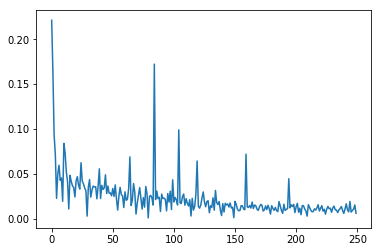

模型保存成功，模型参数保存在LR_model.pdparams中


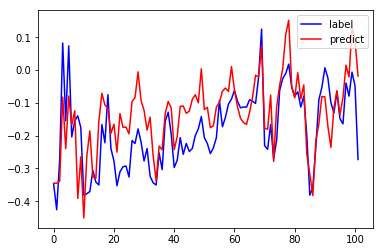

The test loss is: 0.009012306109070778


In [60]:
if __name__ == '__main__':

    # 声明定义好的线性回归模型
    model = Regressor()
    # 开启模型训练模式
    model.train()
    # 加载数据
    training_data, test_data = load_data()
    # 定义优化算法，使用随机梯度下降SGD
    # 学习率设置为0.1
    opt = paddle.optimizer.Adam(learning_rate=0.01, parameters=model.parameters())


    EPOCH_NUM = 50   # 设置外层循环次数
    BATCH_SIZE = 100  # 设置batch大小

    losses = train(EPOCH_NUM, BATCH_SIZE)

    plot_x = np.arange(len(losses))
    plot_y = np.array(losses)
    plt.plot(plot_x, plot_y)
    plt.show()

    # 保存模型参数，文件名为LR_model.pdparams
    paddle.save(model.state_dict(), 'LR_model.pdparams')
    print("模型保存成功，模型参数保存在LR_model.pdparams中")

    testing()             # 测试集上的损失